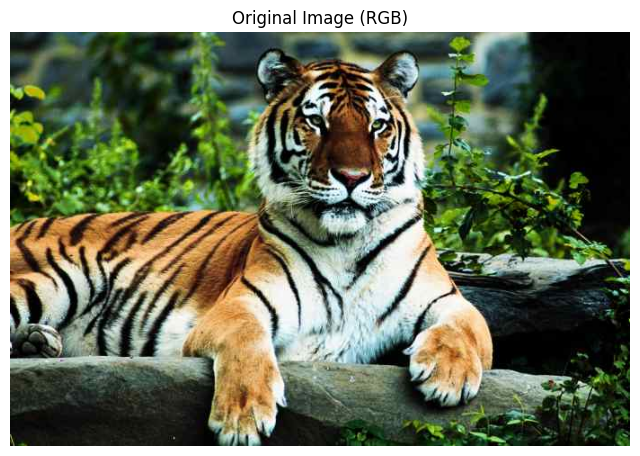

Optimal thresholds for N=4: (48, 109, 177)
Within-group variances: (215.10989944956123, 309.11566689824656, 393.76755381154777, 480.2250946640847)
Final total variance: 321.1087978231897


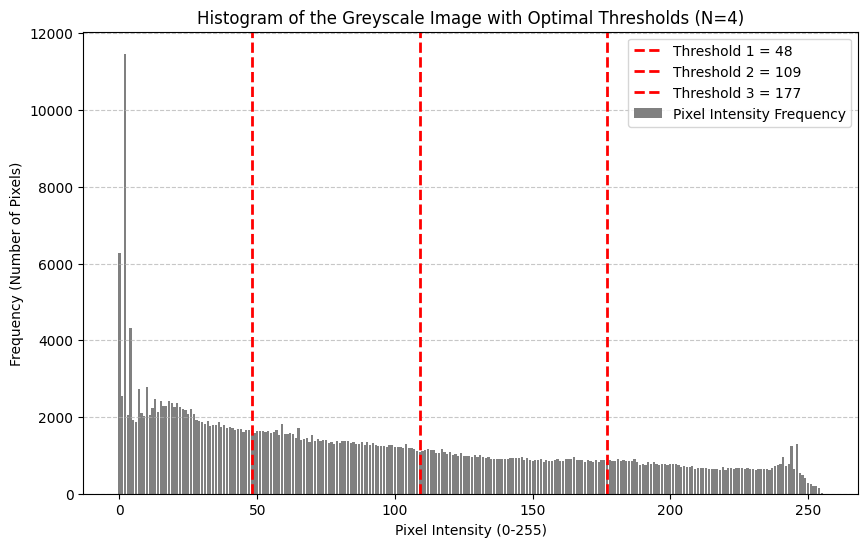

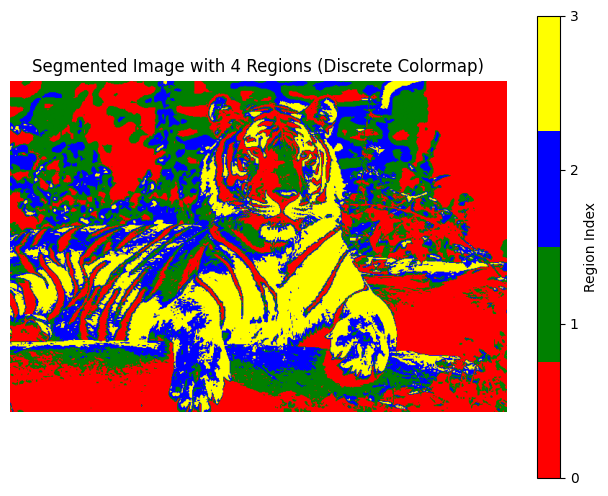

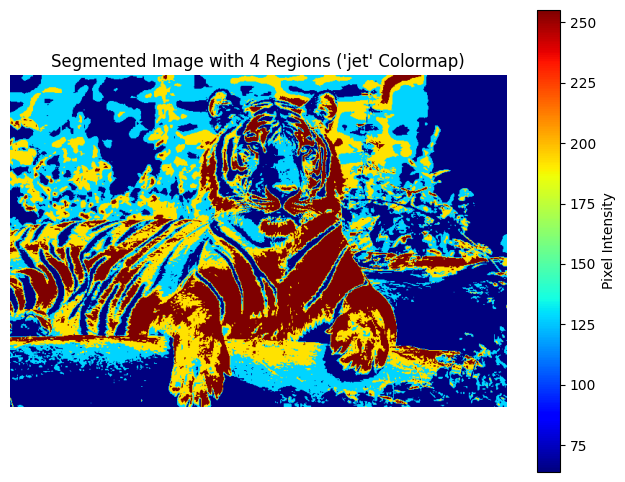

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(115312), np.uint8(128): np.int64(84696), np.uint8(192): np.int64(64194), np.uint8(255): np.int64(53888)}


True

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# ------------------------------
# PART 1: Read and Display the Original Image
# ------------------------------

# Read BMP image using OpenCV (loads as BGR)
image_bgr = cv2.imread("/content/tiger1.bmp")
if image_bgr is None:
    raise FileNotFoundError("Image not found. Check the file path.")

# Convert from BGR to RGB for correct colour display
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Display the original RGB image
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Original Image (RGB)")
plt.show()

# Convert the NumPy array (RGB) to a list of lists of (R, G, B) tuples
rgb_image_list = image_rgb.tolist()

# ------------------------------
# PART 2: Multi-Threshold Otsu Segmentation Functions
# ------------------------------

def convert_to_greyscale(rgb_image):
    """
    Convert an RGB image (list of lists of (R,G,B) tuples)
    to a 2D greyscale image using:
       I = Round(0.299*R + 0.587*G + 0.114*B)
    Returns a 2D list of grey values in [0, 255].
    """
    height = len(rgb_image)
    width = len(rgb_image[0])
    grey_image = [[0] * width for _ in range(height)]
    for r in range(height):
        for c in range(width):
            red, green, blue = rgb_image[r][c]
            grey_val = int(round(0.299 * red + 0.587 * green + 0.114 * blue))
            grey_val = max(0, min(255, grey_val))  # Ensure grey value is within [0, 255]
            grey_image[r][c] = grey_val
    return grey_image

def compute_histogram(grey_image):
    """
    Compute histogram of a 2D greyscale image (8-bit).
    hist[g] counts the number of pixels with grey-level g.
    Returns a list of length 256.
    """
    hist = [0] * 256
    height = len(grey_image)
    width = len(grey_image[0])
    for r in range(height):
        for c in range(width):
            g = grey_image[r][c]
            hist[g] += 1
    return hist

def normalise_histogram(hist):
    """
    Given a histogram 'hist', return its normalised version H(j)
    where sum_j H(j) = 1.
    """
    total_pixels = sum(hist)
    norm_hist = [h / total_pixels for h in hist]
    return norm_hist

def prepare_cumulative_arrays(norm_hist):
    """
    Prepare cumulative sums:
      P(k) = sum_{j=0}^{k} H(j)
      S(k) = sum_{j=0}^{k} j * H(j)
    for k in 0..255.
    Returns two lists P and S (each of length 256).
    """
    P = [0] * 256
    S = [0] * 256
    P[0] = norm_hist[0]
    S[0] = 0.0 * norm_hist[0]
    for k in range(1, 256):
        P[k] = P[k - 1] + norm_hist[k]
        S[k] = S[k - 1] + k * norm_hist[k]
    return P, S

def region_stats(P, S, start_g, end_g):
    """
    Compute (omega, mean, variance) for the region of grey-levels [start_g .. end_g].
    Uses cumulative arrays P and S.
    """
    if start_g == 0:
        omega = P[end_g]
        sum_intensities = S[end_g]
    else:
        omega = P[end_g] - P[start_g - 1]
        sum_intensities = S[end_g] - S[start_g - 1]

    if omega <= 0.0:
        return (0.0, 0.0, 0.0)

    mean_val = sum_intensities / omega
    var_numer = 0.0
    for g in range(start_g, end_g + 1):
        if g == 0:
            h_g = P[g]
        else:
            h_g = P[g] - P[g - 1]
        diff = g - mean_val
        var_numer += (diff * diff) * h_g
    var_val = var_numer / omega

    return (omega, mean_val, var_val)

def otsu_multi_threshold(norm_hist, N):
    """
    Given a normalized histogram (length 256) and a target number of regions N,
    return the thresholds that minimise the total within-class variance,
    along with the within-group variances.

    For N=2, returns a single threshold and variances for two regions.
    For N=3, returns two thresholds and variances for three regions.
    For N=4, returns three thresholds and variances for four regions.
    """
    P, S = prepare_cumulative_arrays(norm_hist)
    best_thresholds = None
    best_within_vars = None
    min_variance = float("inf")

    if N == 2:
        for t in range(0, 255):
            w1, m1, v1 = region_stats(P, S, 0, t)
            w2, m2, v2 = region_stats(P, S, t + 1, 255)
            total_var = w1 * v1 + w2 * v2
            if total_var < min_variance:
                min_variance = total_var
                best_thresholds = (t,)
                best_within_vars = (v1, v2)

    elif N == 3:
        for t1 in range(0, 254):
            for t2 in range(t1 + 1, 255):
                w1, m1, v1 = region_stats(P, S, 0, t1)
                w2, m2, v2 = region_stats(P, S, t1 + 1, t2)
                w3, m3, v3 = region_stats(P, S, t2 + 1, 255)
                total_var = w1 * v1 + w2 * v2 + w3 * v3
                if total_var < min_variance:
                    min_variance = total_var
                    best_thresholds = (t1, t2)
                    best_within_vars = (v1, v2, v3)

    elif N == 4:
        for t1 in range(0, 253):
            for t2 in range(t1 + 1, 254):
                for t3 in range(t2 + 1, 255):
                    w1, m1, v1 = region_stats(P, S, 0, t1)
                    w2, m2, v2 = region_stats(P, S, t1 + 1, t2)
                    w3, m3, v3 = region_stats(P, S, t2 + 1, t3)
                    w4, m4, v4 = region_stats(P, S, t3 + 1, 255)
                    total_var = w1 * v1 + w2 * v2 + w3 * v3 + w4 * v4
                    if total_var < min_variance:
                        min_variance = total_var
                        best_thresholds = (t1, t2, t3)
                        best_within_vars = (v1, v2, v3, v4)

    return best_thresholds, min_variance, best_within_vars

def apply_thresholds_to_image(grey_image, thresholds):
    """
    Given a 2D greyscale image and a tuple of thresholds (t1, t2, ...),
    produce a new 2D image where each region is assigned a unique intensity.
    """
    # Define output intensities for up to 4 regions.
    region_values = [64, 128, 192, 255]
    height = len(grey_image)
    width = len(grey_image[0])
    out_image = [[0] * width for _ in range(height)]
    t_list = sorted(thresholds)

    for r in range(height):
        for c in range(width):
            g = grey_image[r][c]
            region_idx = 0
            while region_idx < len(t_list) and g > t_list[region_idx]:
                region_idx += 1
            out_image[r][c] = region_values[region_idx]

    return out_image

def main_demo(rgb_image, N):
    """
    Full pipeline:
      1. Convert the RGB image to greyscale.
      2. Compute and normalise the histogram.
      3. Display and save the histogram with optimal thresholds.
      4. Apply multi-threshold Otsu segmentation.
      5. Print optimal thresholds, within-group variances and final total variance.
      6. Return the segmented image.
    """
    # Step 1: Convert the RGB image to greyscale
    grey_image = convert_to_greyscale(rgb_image)

    # Step 2: Compute and normalise the histogram
    hist = compute_histogram(grey_image)
    norm_hist = normalise_histogram(hist)

    # Step 3: Apply multi-threshold Otsu segmentation
    thresholds, final_var, within_group_vars = otsu_multi_threshold(norm_hist, N)
    print(f"Optimal thresholds for N={N}:", thresholds)
    print("Within-group variances:", within_group_vars)
    print("Final total variance:", final_var)

    # Step 4: Display and save the histogram with optimal thresholds
    plt.figure(figsize=(10, 6))
    plt.bar(range(256), hist, color='gray', label='Pixel Intensity Frequency')

    # Plot the thresholds as vertical lines
    for i, threshold in enumerate(thresholds):
        plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold {i+1} = {threshold}')

    plt.title(f"Histogram of the Greyscale Image with Optimal Thresholds (N={N})")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency (Number of Pixels)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')  # Add legend to explain the thresholds
    plt.savefig("temp_histogram.png")
    plt.show()

    # Convert the saved PNG to BMP using OpenCV
    temp_hist = cv2.imread("temp_histogram.png")
    cv2.imwrite("data13-histogram.bmp", temp_hist)

    # Step 5: Apply thresholds to the image and get the segmented image
    segmented_image = apply_thresholds_to_image(grey_image, thresholds)
    return segmented_image

# ------------------------------
# PART 3: Run the Segmentation and Display the Result
# ------------------------------

# Choose the number of regions (e.g., 2, 3, or 4)
N = 4  # Change this to 2, 3, or 4 as needed

# Run the full segmentation demo
segmented = main_demo(rgb_image_list, N)

# Convert segmented (a 2D list) to a NumPy array for display/analysis
segmented_np = np.array(segmented, dtype=np.uint8)

# Option 1: Display using a discrete colormap.
# Map the intensities {64, 128, 192, 255} to indices {0, 1, 2, 3}.
mapping = {64: 0, 128: 1, 192: 2, 255: 3}
segmented_mapped = np.vectorize(mapping.get)(segmented_np)

# Define a discrete colormap with distinct colours.
cmap = mcolors.ListedColormap(["red", "green", "blue", "yellow"])
plt.figure(figsize=(8, 6))
plt.imshow(segmented_mapped, cmap=cmap)
plt.axis("off")
plt.title(f"Segmented Image with {N} Regions (Discrete Colormap)")
plt.colorbar(ticks=[0, 1, 2, 3], label="Region Index")
plt.show()

# Option 2: Display using a continuous colormap like 'jet'.
plt.figure(figsize=(8, 6))
plt.imshow(segmented_np, cmap="jet")
plt.axis("off")
plt.title(f"Segmented Image with {N} Regions ('jet' Colormap)")
plt.colorbar(label="Pixel Intensity")
plt.show()

# Verify segmentation by printing unique intensity values.
unique, counts = np.unique(segmented_np, return_counts=True)
print("Unique intensities and counts in segmented image:", dict(zip(unique, counts)))

# Save the segmented image in BMP format with the required naming convention.
cv2.imwrite("data13-out.bmp", segmented_np)

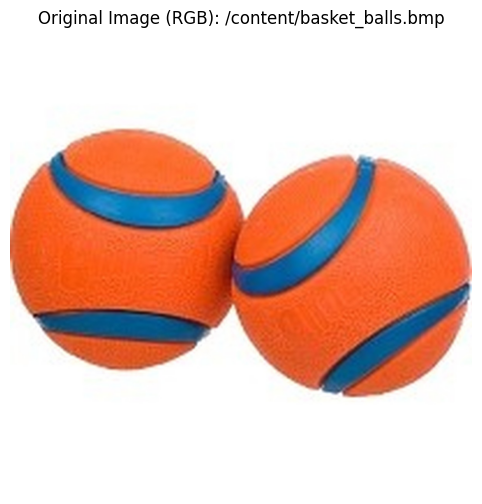


Processing /content/basket_balls.bmp for N=2 regions...


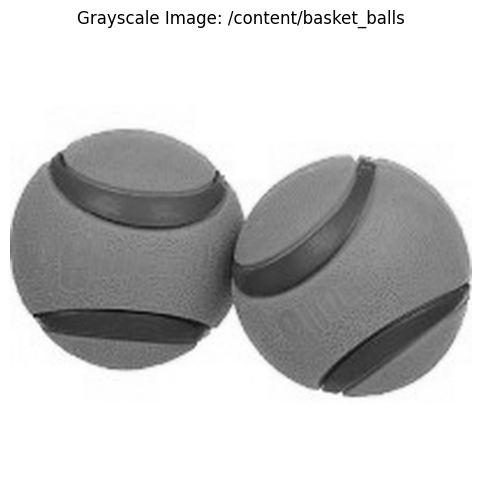

Optimal thresholds for N=2: (187,)
Within-group variances: (742.2857629900019, 30.055614873143995)
Final total variance: 327.73814052981896


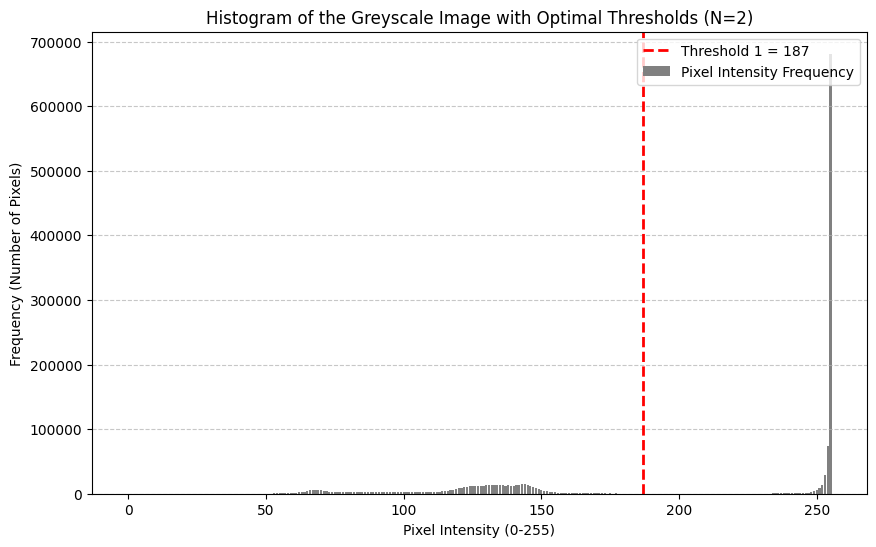

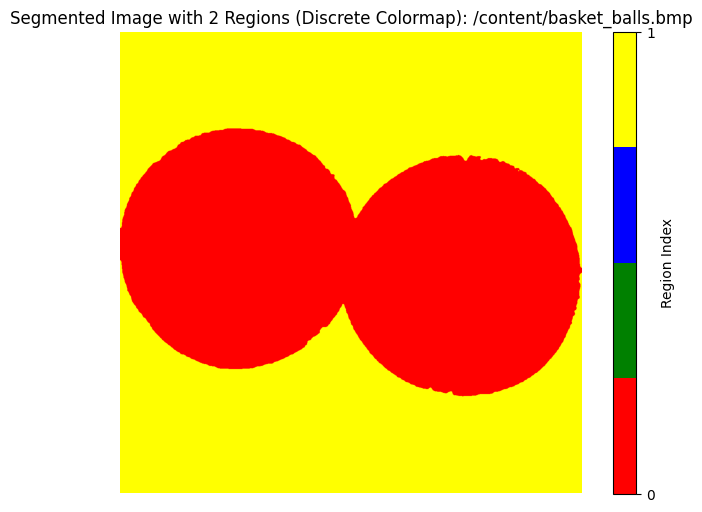

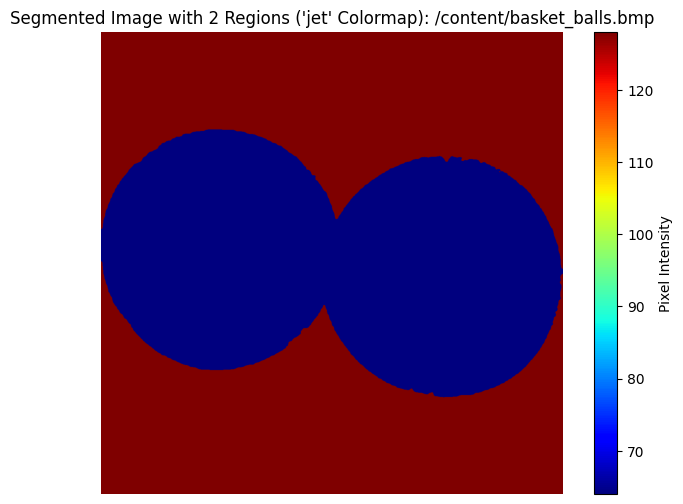

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(601860), np.uint8(128): np.int64(838140)}

Processing /content/basket_balls.bmp for N=3 regions...


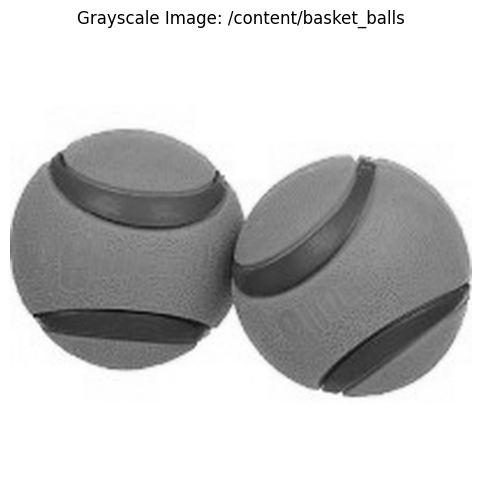

Optimal thresholds for N=3: (106, 194)
Within-group variances: (242.48684987526445, 169.8935607692426, 22.41276008756509)
Final total variance: 91.3995805037327


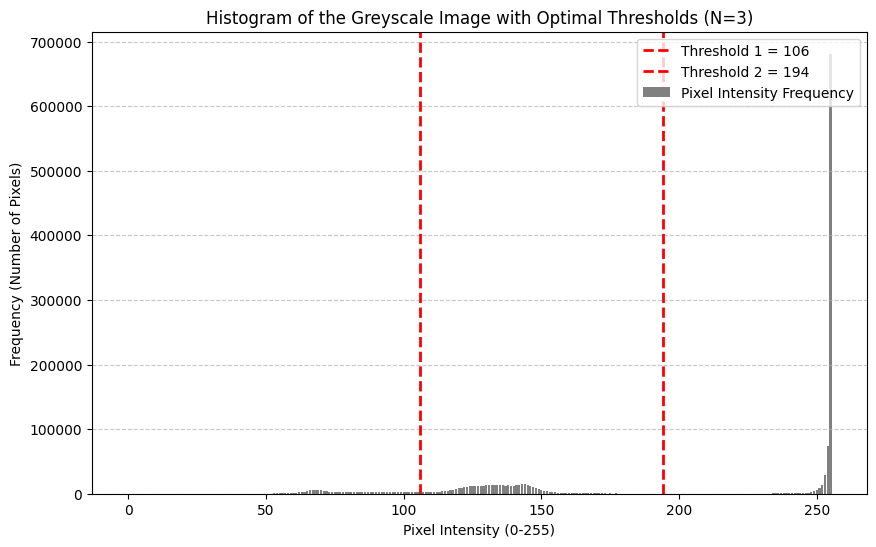

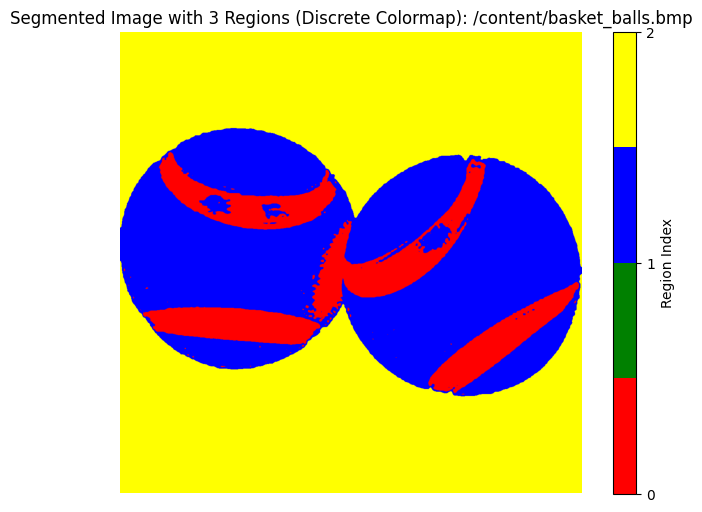

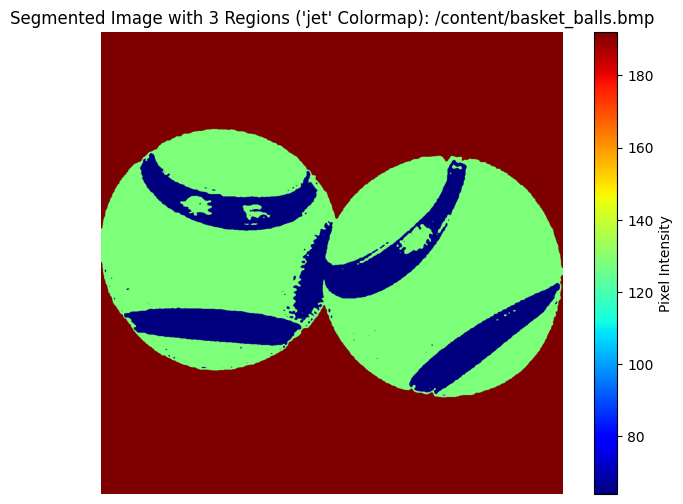

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(142436), np.uint8(128): np.int64(461040), np.uint8(192): np.int64(836524)}

Processing /content/basket_balls.bmp for N=4 regions...


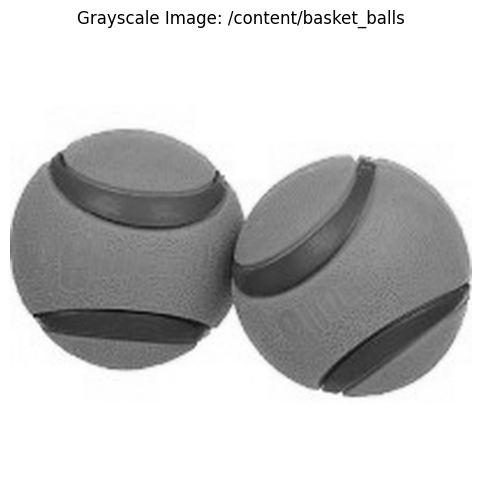

Optimal thresholds for N=4: (99, 133, 199)
Within-group variances: (192.41437130862053, 69.35895232344896, 100.39076712742173, 17.860184646893533)
Final total variance: 55.608803944216966


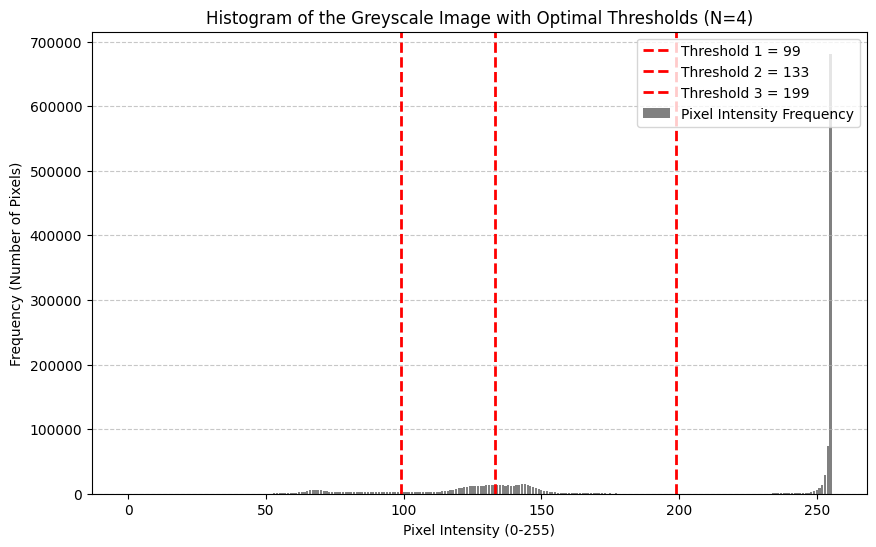

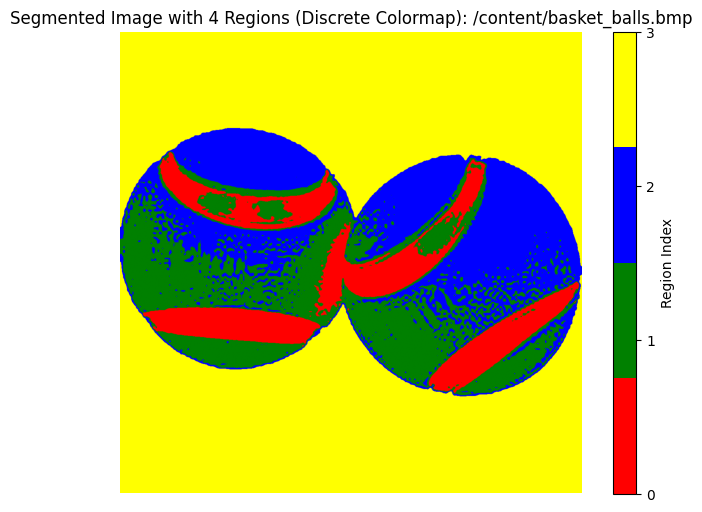

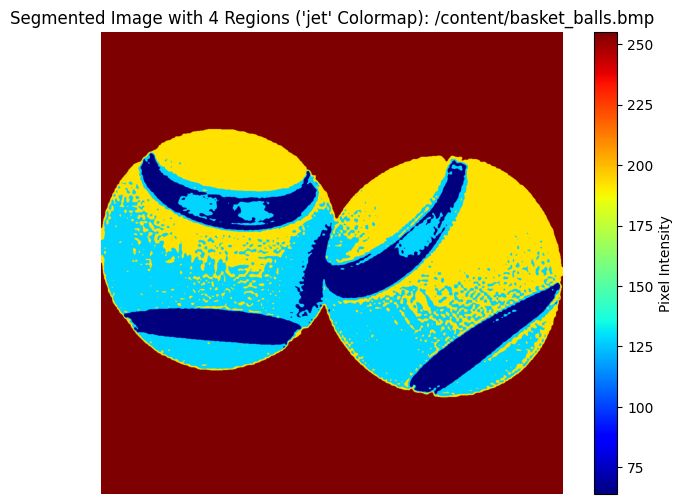

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(126775), np.uint8(128): np.int64(232355), np.uint8(192): np.int64(245520), np.uint8(255): np.int64(835350)}


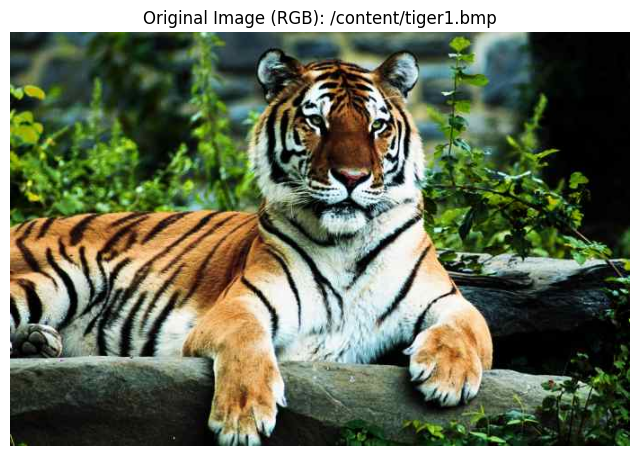


Processing /content/tiger1.bmp for N=2 regions...


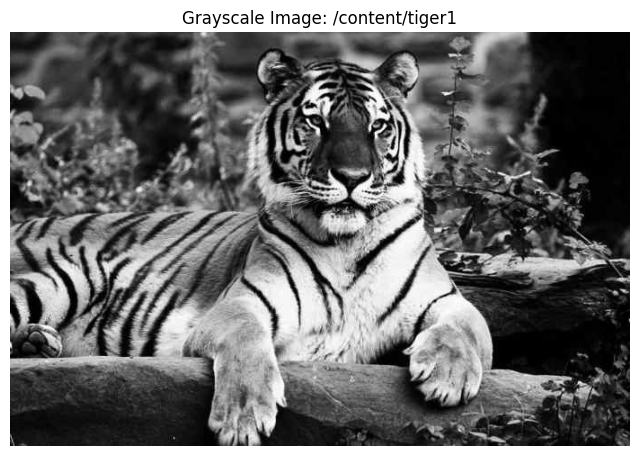

Optimal thresholds for N=2: (108,)
Within-group variances: (1042.5348616782978, 1718.1472538683336)
Final total variance: 1295.6351638032734


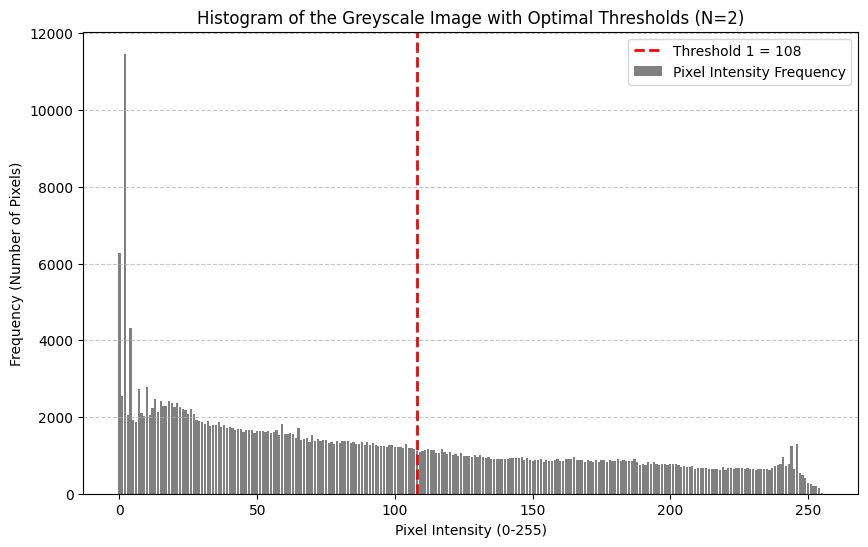

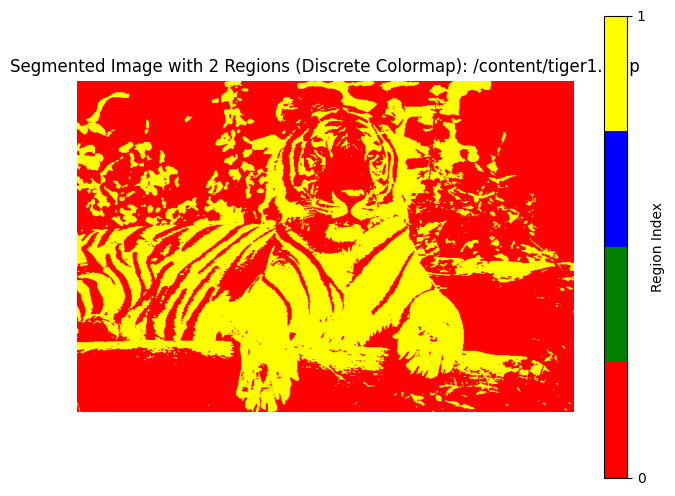

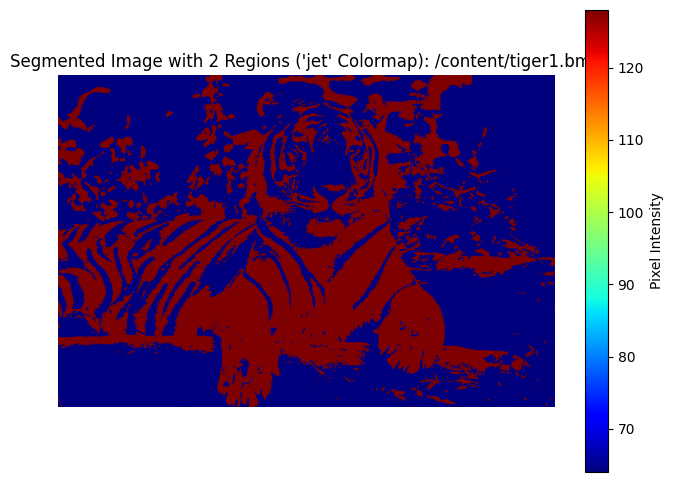

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(198926), np.uint8(128): np.int64(119164)}

Processing /content/tiger1.bmp for N=3 regions...


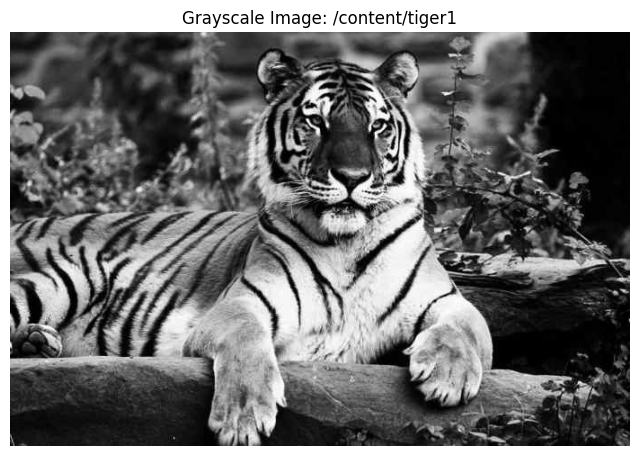

Optimal thresholds for N=3: (66, 152)
Within-group variances: (404.7243463488322, 603.2316734744205, 833.9246770580362)
Final total variance: 568.2176206291498


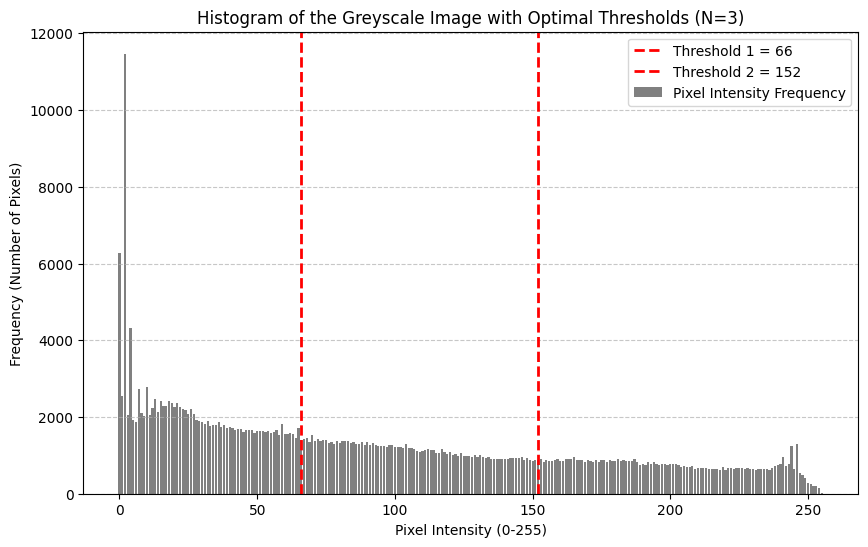

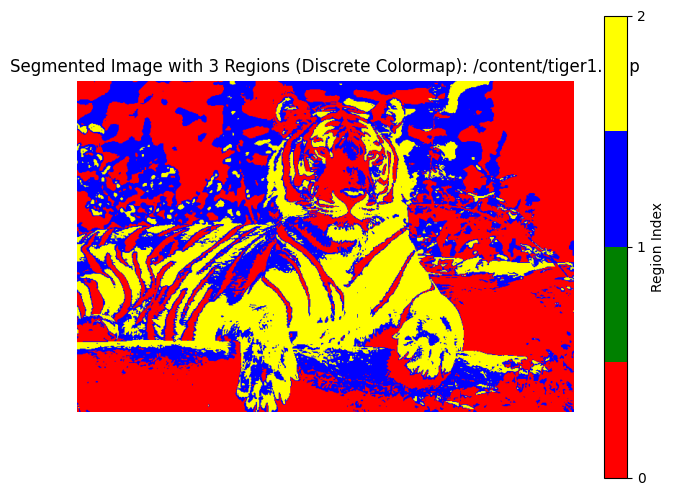

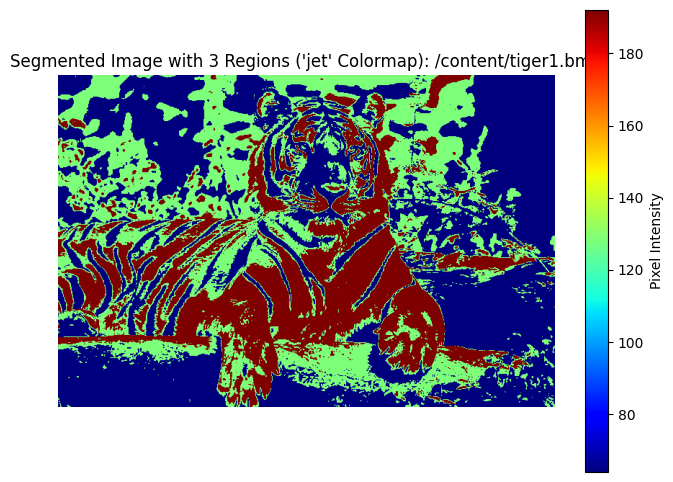

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(144054), np.uint8(128): np.int64(98359), np.uint8(192): np.int64(75677)}

Processing /content/tiger1.bmp for N=4 regions...


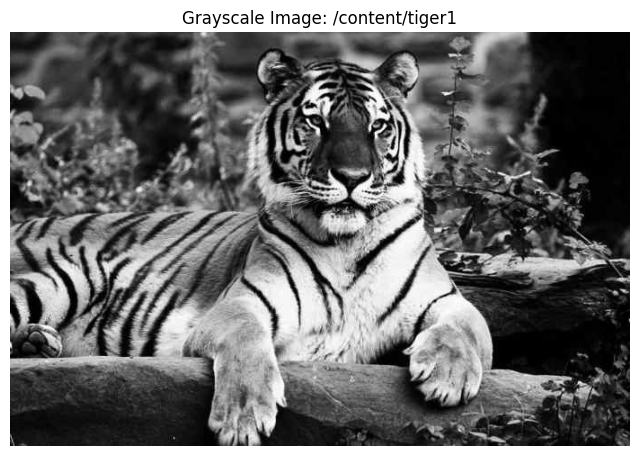

Optimal thresholds for N=4: (48, 109, 177)
Within-group variances: (215.10989944956123, 309.11566689824656, 393.76755381154777, 480.2250946640847)
Final total variance: 321.1087978231897


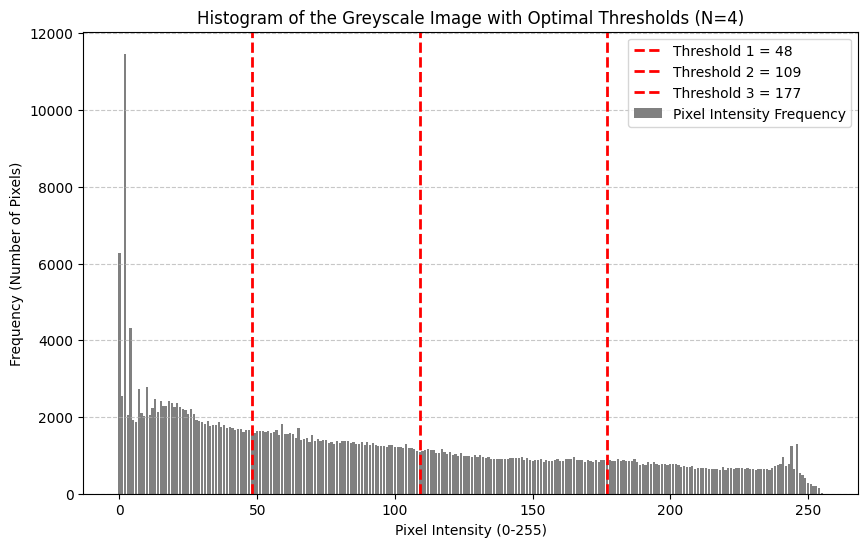

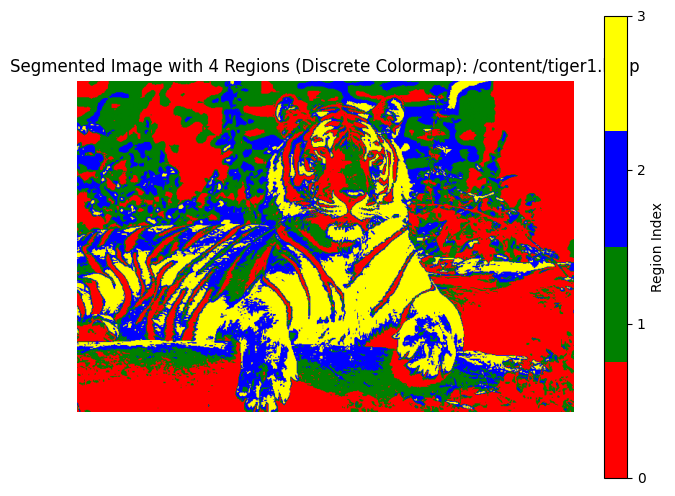

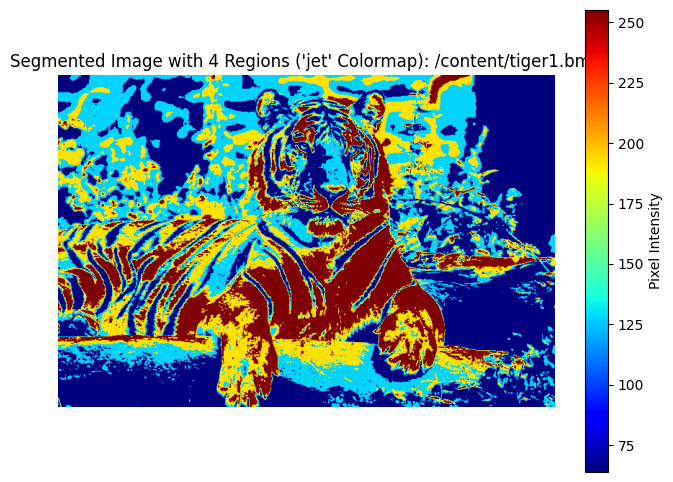

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(115312), np.uint8(128): np.int64(84696), np.uint8(192): np.int64(64194), np.uint8(255): np.int64(53888)}


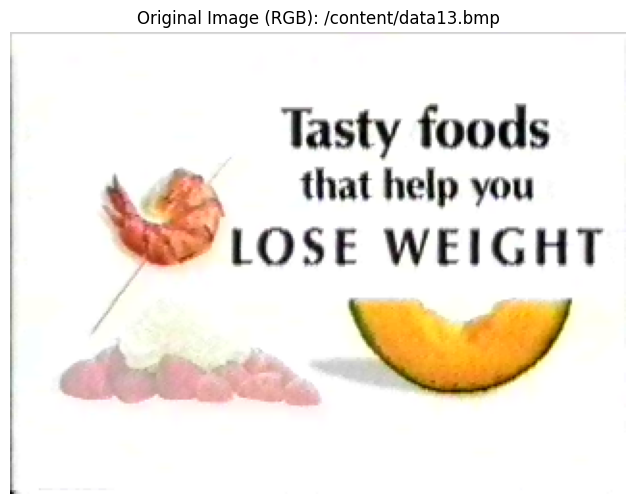


Processing /content/data13.bmp for N=2 regions...


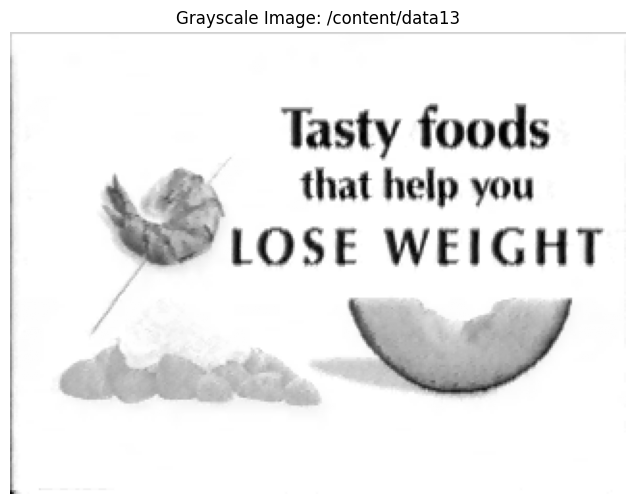

Optimal thresholds for N=2: (192,)
Within-group variances: (3285.22362054694, 138.1840710607791)
Final total variance: 583.9327197497174


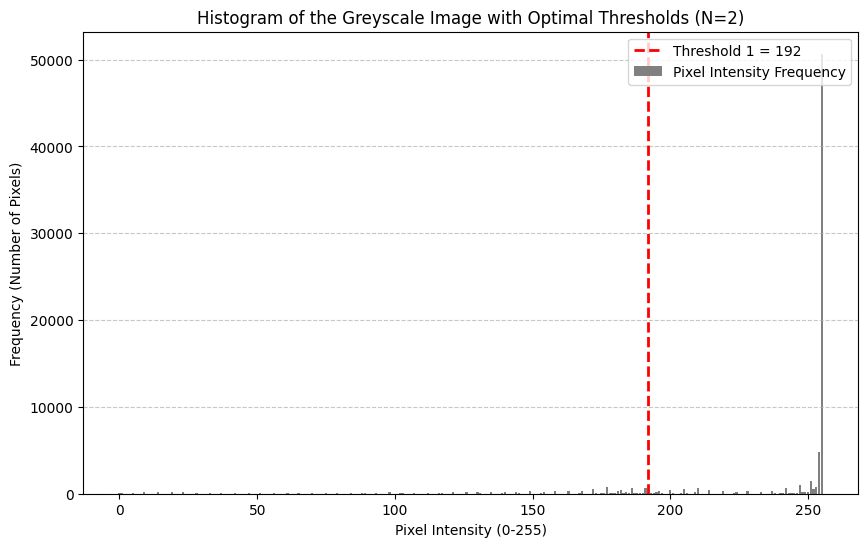

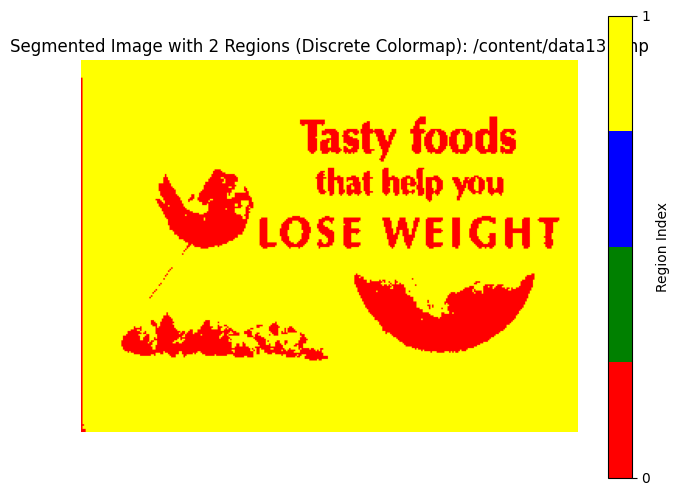

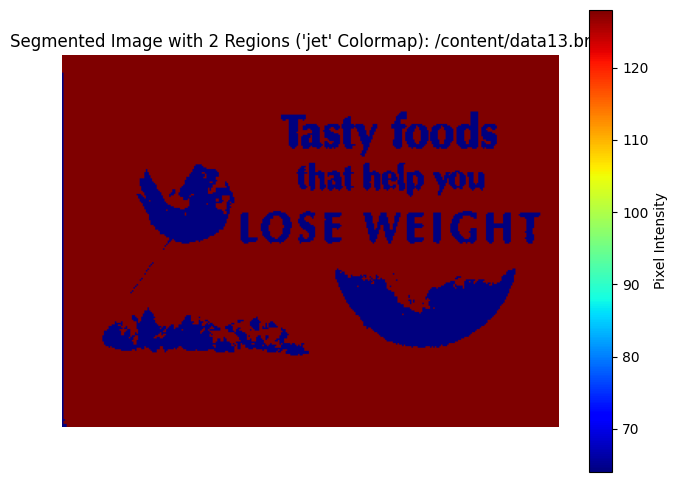

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(10878), np.uint8(128): np.int64(65922)}

Processing /content/data13.bmp for N=3 regions...


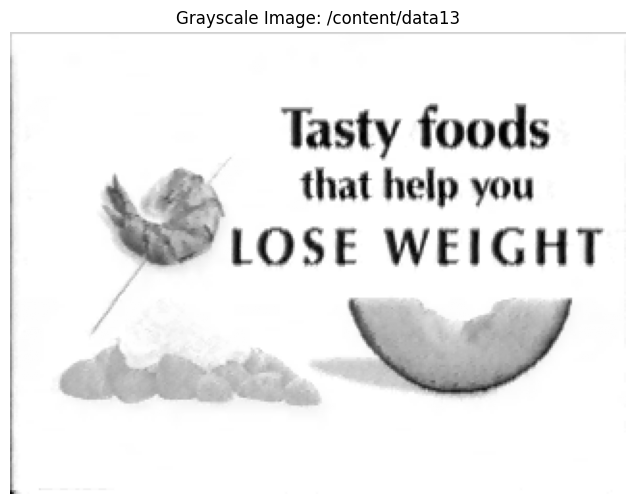

Optimal thresholds for N=3: (119, 216)
Within-group variances: (1369.6422709227709, 541.9420377553428, 24.5790820931552)
Final total variance: 157.3908449719775


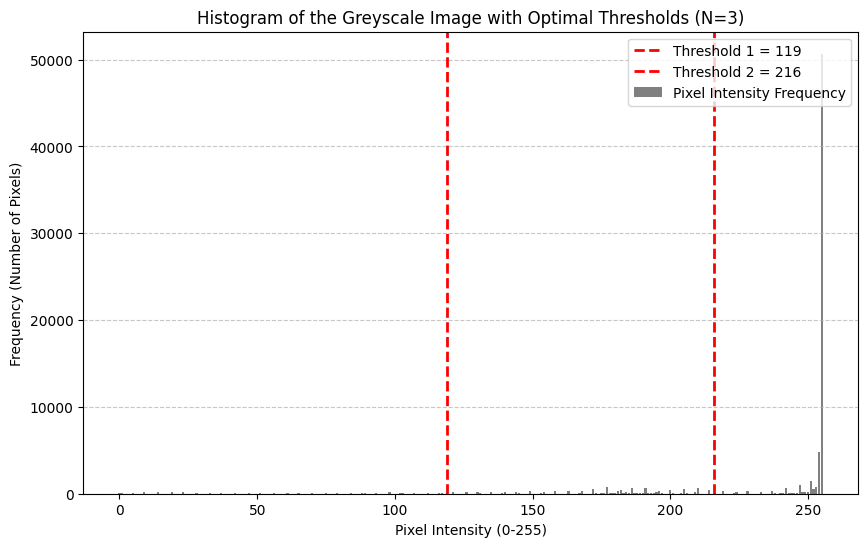

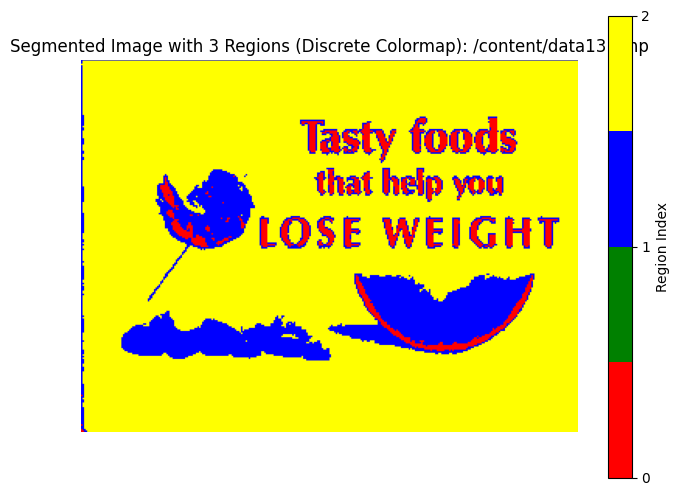

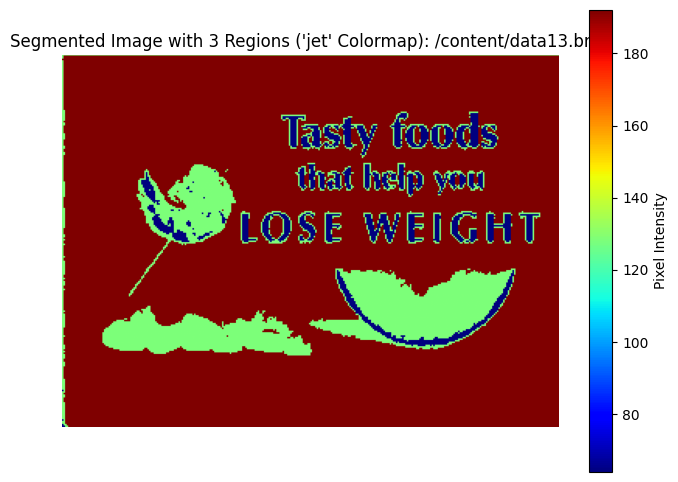

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(3493), np.uint8(128): np.int64(10634), np.uint8(192): np.int64(62673)}

Processing /content/data13.bmp for N=4 regions...


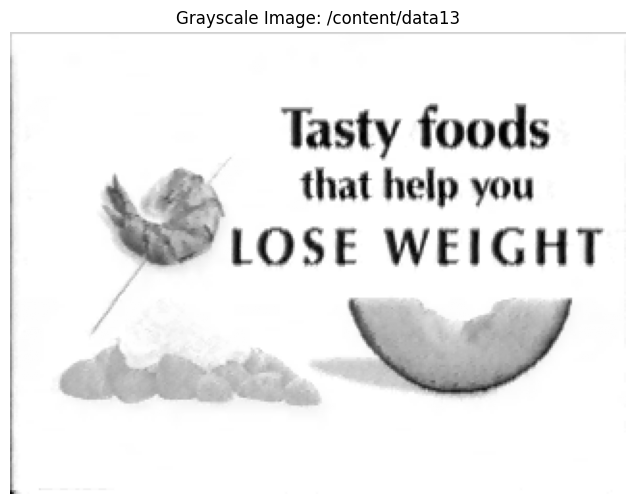

Optimal thresholds for N=4: (76, 154, 221)
Within-group variances: (533.7761499167899, 544.6562993043917, 256.41354796086443, 18.047303563053326)
Final total variance: 82.61031549127041


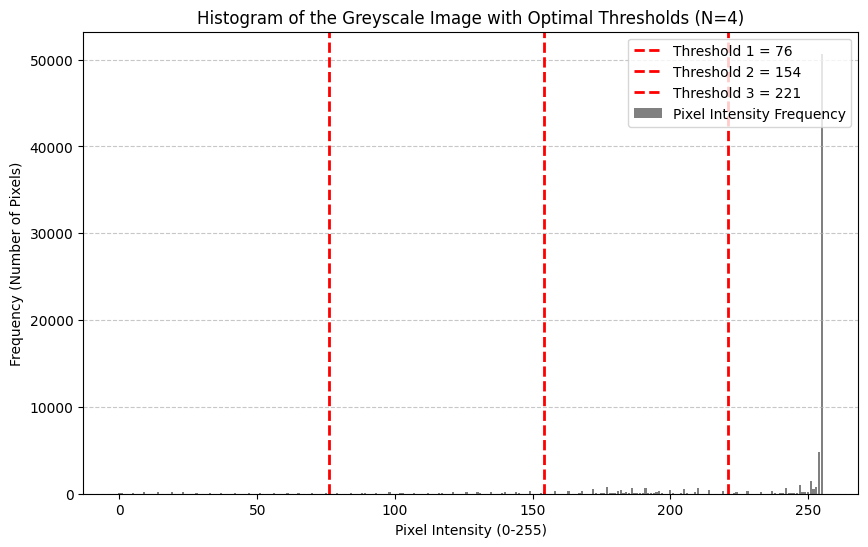

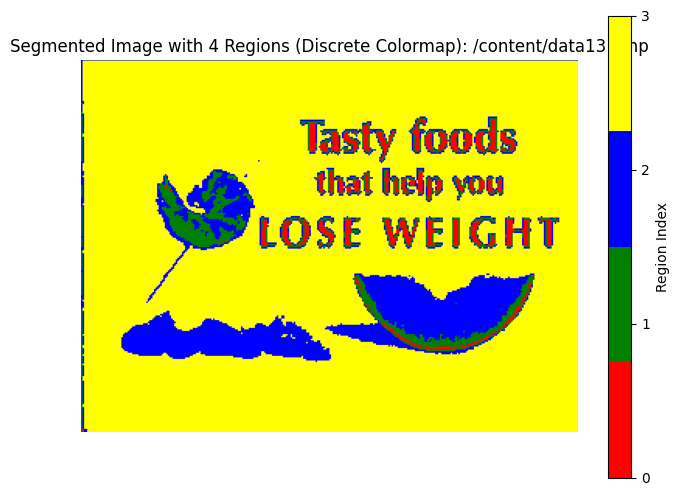

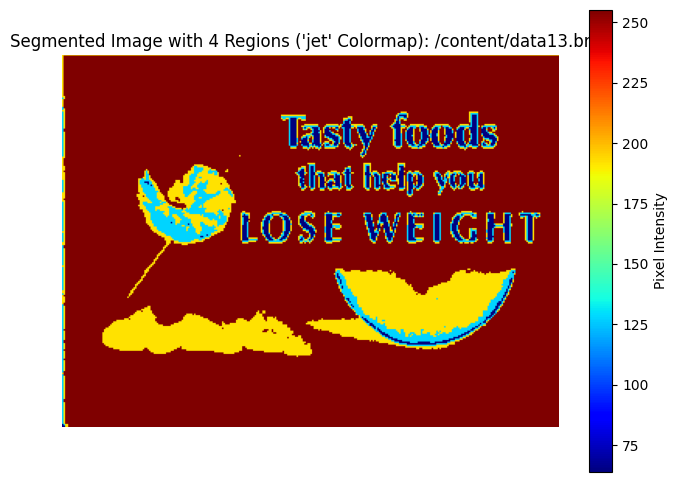

Unique intensities and counts in segmented image: {np.uint8(64): np.int64(2080), np.uint8(128): np.int64(3233), np.uint8(192): np.int64(9159), np.uint8(255): np.int64(62328)}


In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# ------------------------------
# PART 1: Read and Display the Original Images
# ------------------------------

# List of input images
image_files = ["/content/basket_balls.bmp", "/content/tiger1.bmp", "/content/data13.bmp"]

# Loop through each image
for image_file in image_files:
    # Read BMP image using OpenCV (loads as BGR)
    image_bgr = cv2.imread(image_file)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found: {image_file}. Check the file path.")

    # Convert from BGR to RGB for correct colour display
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Display the original RGB image
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Original Image (RGB): {image_file}")
    plt.show()

    # Convert the NumPy array (RGB) to a list of lists of (R, G, B) tuples
    rgb_image_list = image_rgb.tolist()

    # ------------------------------
    # PART 2: Multi-Threshold Otsu Segmentation Functions
    # ------------------------------

    def convert_to_greyscale(rgb_image):
        """
        Convert an RGB image (list of lists of (R,G,B) tuples)
        to a 2D greyscale image using:
           I = Round(0.299*R + 0.587*G + 0.114*B)
        Returns a 2D list of grey values in [0, 255].
        """
        height = len(rgb_image)
        width = len(rgb_image[0])
        grey_image = [[0] * width for _ in range(height)]
        for r in range(height):
            for c in range(width):
                red, green, blue = rgb_image[r][c]
                grey_val = int(round(0.299 * red + 0.587 * green + 0.114 * blue))
                grey_val = max(0, min(255, grey_val))  # Ensure grey value is within [0, 255]
                grey_image[r][c] = grey_val
        return grey_image

    def compute_histogram(grey_image):
        """
        Compute histogram of a 2D greyscale image (8-bit).
        hist[g] counts the number of pixels with grey-level g.
        Returns a list of length 256.
        """
        hist = [0] * 256
        height = len(grey_image)
        width = len(grey_image[0])
        for r in range(height):
            for c in range(width):
                g = grey_image[r][c]
                hist[g] += 1
        return hist

    def normalise_histogram(hist):
        """
        Given a histogram 'hist', return its normalised version H(j)
        where sum_j H(j) = 1.
        """
        total_pixels = sum(hist)
        norm_hist = [h / total_pixels for h in hist]
        return norm_hist

    def prepare_cumulative_arrays(norm_hist):
        """
        Prepare cumulative sums:
          P(k) = sum_{j=0}^{k} H(j)
          S(k) = sum_{j=0}^{k} j * H(j)
        for k in 0..255.
        Returns two lists P and S (each of length 256).
        """
        P = [0] * 256
        S = [0] * 256
        P[0] = norm_hist[0]
        S[0] = 0.0 * norm_hist[0]
        for k in range(1, 256):
            P[k] = P[k - 1] + norm_hist[k]
            S[k] = S[k - 1] + k * norm_hist[k]
        return P, S

    def region_stats(P, S, start_g, end_g):
        """
        Compute (omega, mean, variance) for the region of grey-levels [start_g .. end_g].
        Uses cumulative arrays P and S.
        """
        if start_g == 0:
            omega = P[end_g]
            sum_intensities = S[end_g]
        else:
            omega = P[end_g] - P[start_g - 1]
            sum_intensities = S[end_g] - S[start_g - 1]

        if omega <= 0.0:
            return (0.0, 0.0, 0.0)

        mean_val = sum_intensities / omega
        var_numer = 0.0
        for g in range(start_g, end_g + 1):
            if g == 0:
                h_g = P[g]
            else:
                h_g = P[g] - P[g - 1]
            diff = g - mean_val
            var_numer += (diff * diff) * h_g
        var_val = var_numer / omega

        return (omega, mean_val, var_val)

    def otsu_multi_threshold(norm_hist, N):
        """
        Given a normalized histogram (length 256) and a target number of regions N,
        return the thresholds that minimise the total within-class variance,
        along with the within-group variances.

        For N=2, returns a single threshold and variances for two regions.
        For N=3, returns two thresholds and variances for three regions.
        For N=4, returns three thresholds and variances for four regions.
        """
        P, S = prepare_cumulative_arrays(norm_hist)
        best_thresholds = None
        best_within_vars = None
        min_variance = float("inf")

        if N == 2:
            for t in range(0, 255):
                w1, m1, v1 = region_stats(P, S, 0, t)
                w2, m2, v2 = region_stats(P, S, t + 1, 255)
                total_var = w1 * v1 + w2 * v2
                if total_var < min_variance:
                    min_variance = total_var
                    best_thresholds = (t,)
                    best_within_vars = (v1, v2)

        elif N == 3:
            for t1 in range(0, 254):
                for t2 in range(t1 + 1, 255):
                    w1, m1, v1 = region_stats(P, S, 0, t1)
                    w2, m2, v2 = region_stats(P, S, t1 + 1, t2)
                    w3, m3, v3 = region_stats(P, S, t2 + 1, 255)
                    total_var = w1 * v1 + w2 * v2 + w3 * v3
                    if total_var < min_variance:
                        min_variance = total_var
                        best_thresholds = (t1, t2)
                        best_within_vars = (v1, v2, v3)

        elif N == 4:
            for t1 in range(0, 253):
                for t2 in range(t1 + 1, 254):
                    for t3 in range(t2 + 1, 255):
                        w1, m1, v1 = region_stats(P, S, 0, t1)
                        w2, m2, v2 = region_stats(P, S, t1 + 1, t2)
                        w3, m3, v3 = region_stats(P, S, t2 + 1, t3)
                        w4, m4, v4 = region_stats(P, S, t3 + 1, 255)
                        total_var = w1 * v1 + w2 * v2 + w3 * v3 + w4 * v4
                        if total_var < min_variance:
                            min_variance = total_var
                            best_thresholds = (t1, t2, t3)
                            best_within_vars = (v1, v2, v3, v4)

        return best_thresholds, min_variance, best_within_vars

    def apply_thresholds_to_image(grey_image, thresholds):
        """
        Given a 2D greyscale image and a tuple of thresholds (t1, t2, ...),
        produce a new 2D image where each region is assigned a unique intensity.
        """
        # Define output intensities for up to 4 regions.
        region_values = [64, 128, 192, 255]
        height = len(grey_image)
        width = len(grey_image[0])
        out_image = [[0] * width for _ in range(height)]
        t_list = sorted(thresholds)

        for r in range(height):
            for c in range(width):
                g = grey_image[r][c]
                region_idx = 0
                while region_idx < len(t_list) and g > t_list[region_idx]:
                    region_idx += 1
                out_image[r][c] = region_values[region_idx]

        return out_image

    def main_demo(rgb_image, N, image_name):
        """
        Full pipeline:
          1. Convert the RGB image to greyscale.
          2. Compute and normalise the histogram.
          3. Display and save the histogram with optimal thresholds.
          4. Apply multi-threshold Otsu segmentation.
          5. Print optimal thresholds, within-group variances and final total variance.
          6. Return the segmented image.
        """
        # Step 1: Convert the RGB image to greyscale
        grey_image = convert_to_greyscale(rgb_image)

        # Convert the grayscale image (2D list) to a NumPy array for display/analysis
        grey_image_np = np.array(grey_image, dtype=np.uint8)

        # Display the grayscale image
        plt.figure(figsize=(8, 6))
        plt.imshow(grey_image_np, cmap="gray")
        plt.axis("off")
        plt.title(f"Grayscale Image: {image_name}")
        plt.show()

        # Save the grayscale image in BMP format
        cv2.imwrite(f"{image_name}-grayscale.bmp", grey_image_np)

        # Step 2: Compute and normalise the histogram
        hist = compute_histogram(grey_image)
        norm_hist = normalise_histogram(hist)

        # Step 3: Apply multi-threshold Otsu segmentation
        thresholds, final_var, within_group_vars = otsu_multi_threshold(norm_hist, N)
        print(f"Optimal thresholds for N={N}:", thresholds)
        print("Within-group variances:", within_group_vars)
        print("Final total variance:", final_var)

        # Step 4: Display and save the histogram with optimal thresholds
        plt.figure(figsize=(10, 6))
        plt.bar(range(256), hist, color='gray', label='Pixel Intensity Frequency')

        # Plot the thresholds as vertical lines
        for i, threshold in enumerate(thresholds):
            plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold {i+1} = {threshold}')

        plt.title(f"Histogram of the Greyscale Image with Optimal Thresholds (N={N})")
        plt.xlabel("Pixel Intensity (0-255)")
        plt.ylabel("Frequency (Number of Pixels)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(loc='upper right')  # Add legend to explain the thresholds
        plt.savefig(f"{image_name}-histogram.png")
        plt.show()

        # Convert the saved PNG to BMP using OpenCV
        temp_hist = cv2.imread(f"{image_name}-histogram.png")
        cv2.imwrite(f"{image_name}-histogram.bmp", temp_hist)

        # Step 5: Apply thresholds to the image and get the segmented image
        segmented_image = apply_thresholds_to_image(grey_image, thresholds)
        return segmented_image

    # ------------------------------
    # PART 3: Run the Segmentation and Display the Result
    # ------------------------------

    # Loop through the number of regions (2, 3, 4)
    for N in [2, 3, 4]:
        print(f"\nProcessing {image_file} for N={N} regions...")

        # Run the full segmentation demo
        segmented = main_demo(rgb_image_list, N, image_file.split(".")[0])

        # Convert segmented (a 2D list) to a NumPy array for display/analysis
        segmented_np = np.array(segmented, dtype=np.uint8)

        # Option 1: Display using a discrete colormap.
        # Map the intensities {64, 128, 192, 255} to indices {0, 1, 2, 3}.
        mapping = {64: 0, 128: 1, 192: 2, 255: 3}
        segmented_mapped = np.vectorize(mapping.get)(segmented_np)

        # Define a discrete colormap with distinct colours.
        cmap = mcolors.ListedColormap(["red", "green", "blue", "yellow"])
        plt.figure(figsize=(8, 6))
        plt.imshow(segmented_mapped, cmap=cmap)
        plt.axis("off")
        plt.title(f"Segmented Image with {N} Regions (Discrete Colormap): {image_file}")
        plt.colorbar(ticks=[0, 1, 2, 3], label="Region Index")
        plt.show()

        # Option 2: Display using a continuous colormap like 'jet'.
        plt.figure(figsize=(8, 6))
        plt.imshow(segmented_np, cmap="jet")
        plt.axis("off")
        plt.title(f"Segmented Image with {N} Regions ('jet' Colormap): {image_file}")
        plt.colorbar(label="Pixel Intensity")
        plt.show()

        # Verify segmentation by printing unique intensity values.
        unique, counts = np.unique(segmented_np, return_counts=True)
        print("Unique intensities and counts in segmented image:", dict(zip(unique, counts)))

        # Save the segmented image in BMP format with the required naming convention.
        cv2.imwrite(f"{image_file.split('.')[0]}-out-N{N}.bmp", segmented_np)